This notebook plots training MSE and test MSE of polynomial models for different generative distributions (different noises and different classes of f(X)) and different numbers of samples.  

#### Load libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# Set the resolution of the images (higher than default)
# you may need to re-run this for dpi to be reset
plt.rcParams['figure.dpi'] = 150
#plt.rcParams['savefig.dpi'] = 300

In [3]:
# you may need to re-run this for dpi to be reset
plt.rcParams['figure.dpi'] = 150
#plt.rcParams['savefig.dpi'] = 300

#### Define a ground-truth deterministic function f() for Y=f(X)+$\epsilon$ 

In [7]:
def f(x,f_type='quadratic'):
    # function to approximate by polynomial interpolation
       
    #linear   
    if f_type=='linear':
      return -3+ 0.5*x 
    
    #quadratic       
    if f_type=='quadratic': 
        return -2 -x + 0.2*x**2 
    
    #sinusoidal       
    if f_type=='sinusoidal':
        return x * np.sin(x)

#### Define a function to generate i.i.d. samples, first generating X and then Y=f(X)+$\epsilon$ 

We will generate X as i.i.d. Uniform(0,10) and the noise $\epsilon$ as i.i.d. $N(0,\sigma^2)$

In [8]:
def get_data(n=100,sigma=1,f_type='linear'):
    #Generate a data set with n samples using Gaussian noise with variance sigma^2
    X = np.random.uniform(0,10,n)
    Y = f(X,f_type)+ np.random.normal(0, sigma, n)
    return X,Y

### We will fit polynomial models with different orders (eg. a constant function, a linear, a quadratic, ...) and compare their training MSE and test MSE, where for test MSE we generate a large amount of new data.


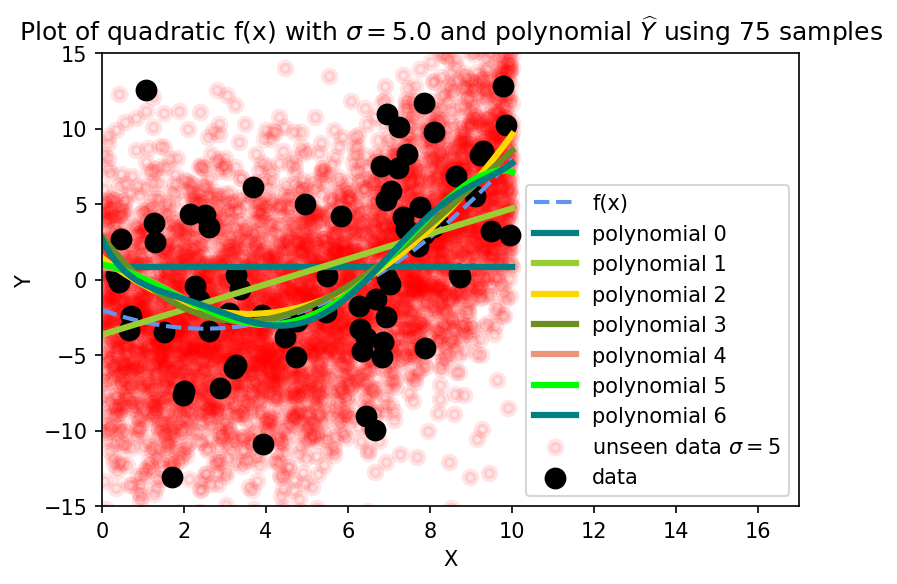

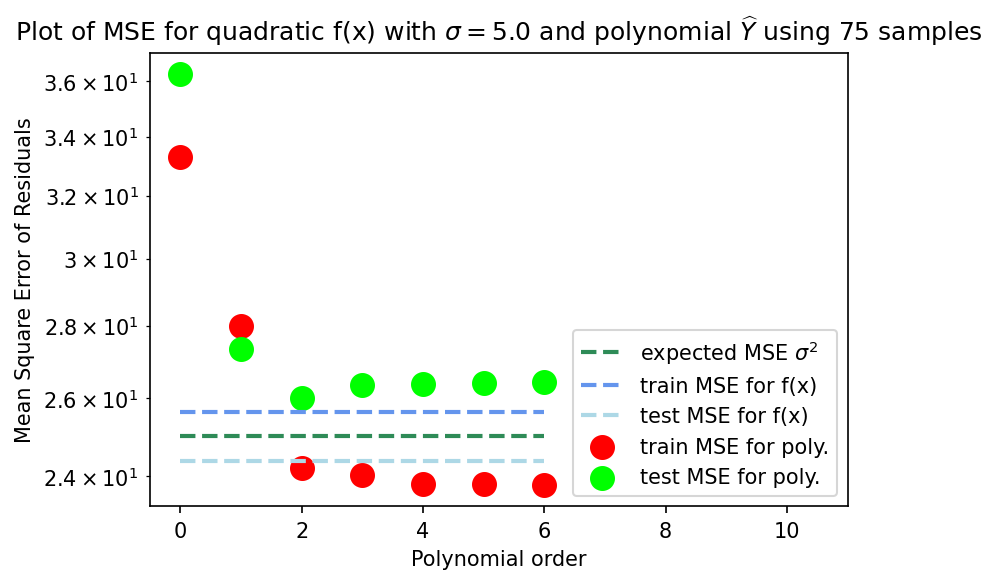

In [9]:
#Specify settings for the data set

f_type = 'quadratic'   #options: ('linear','quadratic','sinusoidal')
n_samples =  75     # number of training samples
sigma_ = 5          # noise standard deviation




max_degree = 6

colors_fit = ['teal', 'yellowgreen', 'gold','olivedrab','darksalmon','lime'] 
#for a gallery of named colors, see https://matplotlib.org/stable/gallery/color/named_colors.html

plt.figure()

#iid test samples to plot   -- plot in background 
test_X,test_Y = get_data(5000,sigma_,f_type)
label_ = r'unseen data $\sigma=$%i'%(sigma_) #label for plotting

plt.scatter(test_X, test_Y, marker='o', s=30,color='red',alpha=.1,label=label_,linewidth=3) 

#iid training samples
X,Y = get_data(n_samples,sigma_,f_type)
plt.scatter(X, Y, marker='o', s=30,color='black',label='data',linewidth=5) #plot the data points

#draw a curve of f(x) for reference
x_curve = np.linspace(0, 10,100)
y_curve = f(x_curve,f_type=f_type)
plt.plot(x_curve, y_curve, '--',color='cornflowerblue', label='f(x)',linewidth=2)

mse_scores = [] #for each polynomial, track training error. (eg fit on the data set)
mse_scores_test = [] #for each polynomial, track training error. (eg. fit on future data)

for degree in range(max_degree+1):
    
    model = make_pipeline(PolynomialFeatures(degree), StandardScaler(), LinearRegression())
    model.fit(X[:,np.newaxis], Y)

    #plot a few curves
    if degree in range(max_degree+1): #[0,1,2,max_degree]:
        y_plot_fit = model.predict(x_curve[:,np.newaxis])
        plt.plot(x_curve, y_plot_fit, color=colors_fit[degree%len(colors_fit)], linewidth=3,label="polynomial %i" % (degree))
    
    mse = mean_squared_error(Y, model.predict(X[:,np.newaxis]))
    mse_scores.append(mse)
    #print('Mean squared error on data set for degree %i: %.2f' % (degree,mse))
    
    mse_test = mean_squared_error(test_Y, model.predict(test_X[:,np.newaxis]))
    mse_scores_test.append(mse_test)
    #print('Mean squared error on data set for degree %i: %.2f' % (degree,mse_test))
    

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, 17)
plt.ylim(-15, 15)
plt.title(r'Plot of %s f(x) with $\sigma=$%0.1f and polynomial $\widehat{Y}$ using %i samples'%(f_type,sigma_,n_samples))
plt.legend(loc='lower right')
plt.show()

#calculate training MSE of the correct model
mse_true_model = mean_squared_error(Y, f(X,f_type=f_type))
#calculate training MSE of the correct model on test data
mse_true_model_test = mean_squared_error(test_Y, f(test_X,f_type=f_type))

#now plot training error
plt.figure()
plt.scatter(range(max_degree+1), mse_scores,color='red',linewidth=6,label='train MSE for poly.')
plt.scatter(range(max_degree+1), mse_scores_test,color='lime',linewidth=6,label='test MSE for poly.')

plt.plot([0,max_degree], [sigma_**2,sigma_**2], '--',color='seagreen', label=r'expected MSE $\sigma^2$',linewidth=2)
plt.plot([0,max_degree], [mse_true_model,mse_true_model], '--',color='cornflowerblue', label='train MSE for f(x)',linewidth=2)
plt.plot([0,max_degree], [mse_true_model_test,mse_true_model_test], '--',color='lightblue', label='test MSE for f(x)',linewidth=2)

plt.title('Plot of training error for one data set of %i samples '%(n_samples))
plt.title(r'Plot of MSE for %s f(x) with $\sigma=$%0.1f and polynomial $\widehat{Y}$ using %i samples'%(f_type,sigma_,n_samples))

plt.xlabel("Polynomial order")
plt.ylabel("Mean Square Error of Residuals")
plt.xlim([-.5,max_degree+5])
#plt.ylim(0,50)
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()